In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
words = open('names.txt', 'r').read().split()
words[:3]

['emma', 'olivia', 'ava']

In [24]:
len(words)

32033

In [25]:
# Mapping

stoi = {s:i+1 for i,s in enumerate(sorted(list(set(''.join(words)))))}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [26]:
# build the dataset

def build_dataset(words: list[str]):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for chr in w + '.':
            X.append(context)
            ichr = stoi[chr]
            Y.append(ichr)
            context = context[1:] + [ichr]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Train, Val/Dev, Test split
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [27]:
# MLP parameters

g = torch.Generator().manual_seed(2147483647)

n_embedd = 10 # Embedding dim
C = torch.randn((vocab_size, n_embedd), generator=g) # Lookup matrix for embedding
block_size = 3

n_hidden = 200

# Layer 1
W1 = torch.randn((n_embedd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True



Total number of parameters :  11897


In [28]:
# Training

max_steps = 200000
batch_size = 32
lossi = [] # training loss in each step

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer out
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Yb) #loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the stats
    if i % 10000 == 0:
        print(f'{i:7d} /  {max_steps:7d} :: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

      0 /   200000 :: 27.8817
  10000 /   200000 :: 2.8138
  20000 /   200000 :: 2.5218
  30000 /   200000 :: 2.7874
  40000 /   200000 :: 2.0334
  50000 /   200000 :: 2.6237
  60000 /   200000 :: 2.3289
  70000 /   200000 :: 2.0826
  80000 /   200000 :: 2.2784
  90000 /   200000 :: 2.2252
 100000 /   200000 :: 2.0428
 110000 /   200000 :: 2.3121
 120000 /   200000 :: 2.0570
 130000 /   200000 :: 2.4546
 140000 /   200000 :: 2.2233
 150000 /   200000 :: 2.1551
 160000 /   200000 :: 2.0597
 170000 /   200000 :: 1.7981
 180000 /   200000 :: 2.0194
 190000 /   200000 :: 1.7459


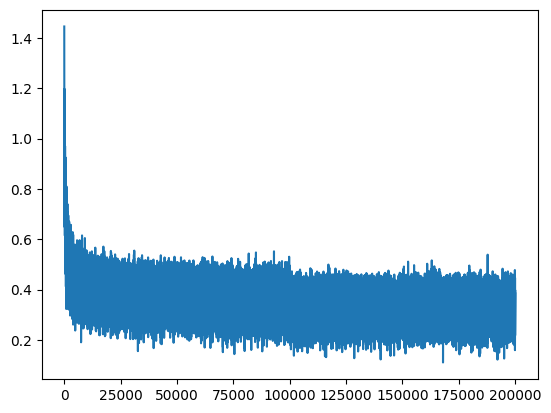

In [29]:
plt.plot(lossi)

In [34]:
@torch.no_grad
def split_loss(split):

    x, y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, ' loss : ', loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')


train  loss :  2.1267659664154053
dev  loss :  2.1697638034820557
test  loss :  2.1623899936676025


In [41]:
g = torch.Generator().manual_seed(2147483647 + 10)

def predict_ix(context):
    emb = C[torch.tensor(context)]
    embcat = emb.view(1, -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1, replacement=True, generator=g)
    return ix.item()

# Sample from the model

for _ in range(10):

    out = []
    context = [0] * 3
    while True:
        ix = predict_ix(context)
        out.append(ix)
        context = context[1:] + [ix]

        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out]))


carlah.
amorie.
khirmin.
rey.
cassanden.
jazhubedah.
sart.
kaeli.
nellara.
chaiir.


We can see the loss at very begining is very high around 27 and then in next step comes to around 3. If we think through about the loss at initialisation, the moidel is likely to predict any character next. So we expect a uniform probability of (1/27) for all characters.

In [44]:
loss = -torch.tensor((1/27)).log()
loss.item()

3.295836925506592

## Scaling down weight

Total number of parameters :  11897
      0 /   200000 :: 3.3221
  10000 /   200000 :: 2.1900
  20000 /   200000 :: 2.4196
  30000 /   200000 :: 2.6067
  40000 /   200000 :: 2.0601
  50000 /   200000 :: 2.4988
  60000 /   200000 :: 2.3902
  70000 /   200000 :: 2.1344
  80000 /   200000 :: 2.3369
  90000 /   200000 :: 2.1299
 100000 /   200000 :: 1.8329
 110000 /   200000 :: 2.2053
 120000 /   200000 :: 1.8540
 130000 /   200000 :: 2.4566
 140000 /   200000 :: 2.1879
 150000 /   200000 :: 2.1118
 160000 /   200000 :: 1.8956
 170000 /   200000 :: 1.8644
 180000 /   200000 :: 2.0326
 190000 /   200000 :: 1.8417


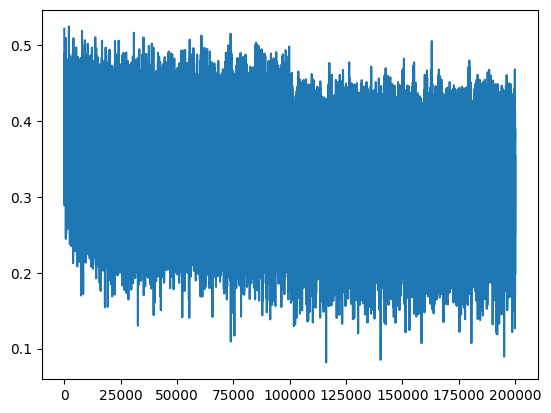

In [45]:
# MLP parameters

g = torch.Generator().manual_seed(2147483647)

n_embedd = 10 # Embedding dim
C = torch.randn((vocab_size, n_embedd), generator=g) # Lookup matrix for embedding
block_size = 3

n_hidden = 200

# Layer 1
W1 = torch.randn((n_embedd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # We want logits to be close to zero. So scaling down weights and removing bias
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = [] # training loss in each step

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer out
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Yb) #loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the stats
    if i % 10000 == 0:
        print(f'{i:7d} /  {max_steps:7d} :: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())


plt.plot(lossi)

Now the initial loss has come down to 3 initialy, and the hockey stick curve has changed.

We might have get away with logits, but the hidden state initialisation is still might not be optimised. Let's have a look at the values of hidden state in first iteration.

In [46]:
# MLP parameters

g = torch.Generator().manual_seed(2147483647)

n_embedd = 10 # Embedding dim
C = torch.randn((vocab_size, n_embedd), generator=g) # Lookup matrix for embedding
block_size = 3

n_hidden = 200

# Layer 1
W1 = torch.randn((n_embedd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # We want logits to be close to zero. So scaling down weights and removing bias
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = [] # training loss in each step

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer out
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Yb) #loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the stats
    if i % 10000 == 0:
        print(f'{i:7d} /  {max_steps:7d} :: {loss.item():.4f}')
    
    break

Total number of parameters :  11897
      0 /   200000 :: 3.3221


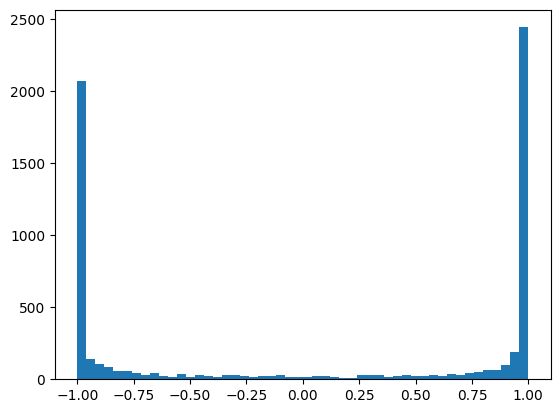

In [51]:
plt.hist(h.view(-1).tolist(), bins=50);

A lot of activation are in -1 and 1, which we dont want. Why?
if tanh(x) = t, then
d/dx (tanh(x)) = 1 - t**2, if t takes values 1 and -1, then d/dx -> 0

When we update the parameters with grad, d/dx * grad, this would also be 0, No updation happens at these neurons, which is not want we want.

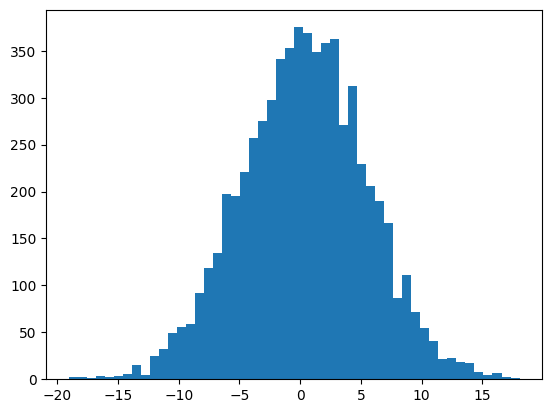

In [52]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

A lot of these takes extreme values

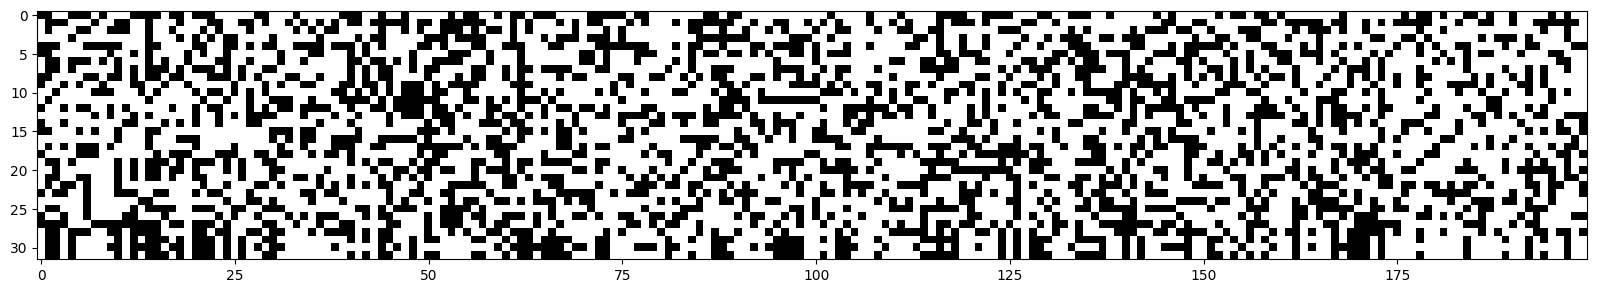

In [54]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

The which space represent the activations in tail region, where the gradient is killed. There are alot of these. If there is a column of white across all neurons, then thats a dead neuron. It doesn't learn anything.

Lets reduce W1 and b1

In [55]:
# MLP parameters

g = torch.Generator().manual_seed(2147483647)

n_embedd = 10 # Embedding dim
C = torch.randn((vocab_size, n_embedd), generator=g) # Lookup matrix for embedding
block_size = 3

n_hidden = 200

# Layer 1
W1 = torch.randn((n_embedd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # We want logits to be close to zero. So scaling down weights and removing bias
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = [] # training loss in each step

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer out
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Yb) #loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the stats
    if i % 10000 == 0:
        print(f'{i:7d} /  {max_steps:7d} :: {loss.item():.4f}')
    
    break

Total number of parameters :  11897
      0 /   200000 :: 3.3069


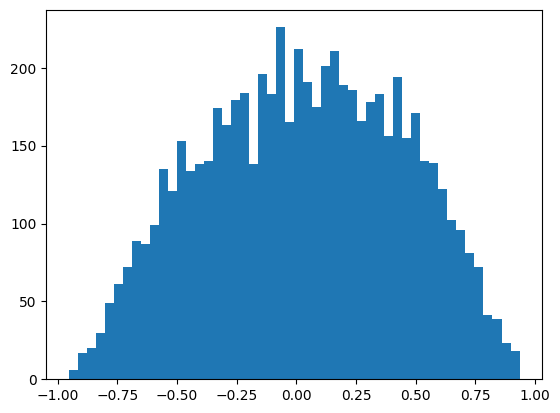

In [56]:
plt.hist(h.view(-1).tolist(), bins=50);

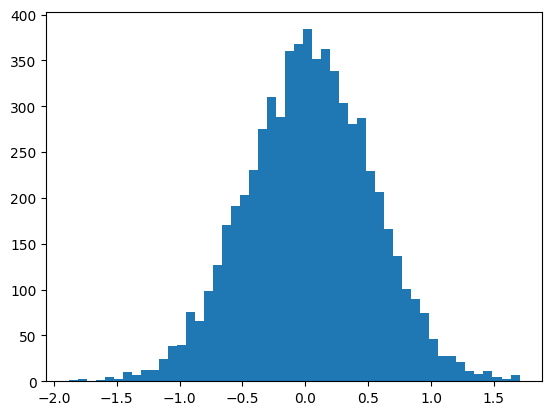

In [57]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

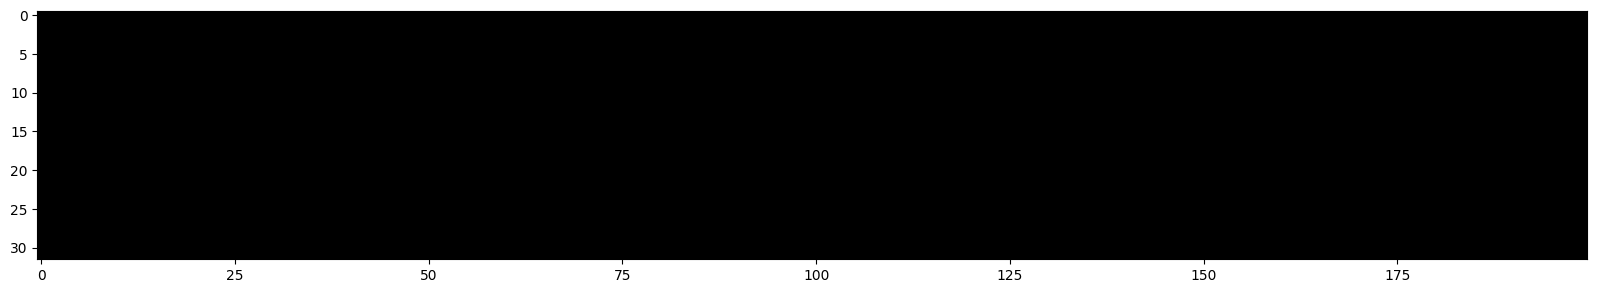

In [58]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Total number of parameters :  11897
      0 /   200000 :: 3.3069
  10000 /   200000 :: 2.1900
  20000 /   200000 :: 2.2707
  30000 /   200000 :: 2.4296
  40000 /   200000 :: 1.9041
  50000 /   200000 :: 2.3865
  60000 /   200000 :: 2.3392
  70000 /   200000 :: 2.0873
  80000 /   200000 :: 2.2595
  90000 /   200000 :: 2.1146
 100000 /   200000 :: 1.8817
 110000 /   200000 :: 2.1622
 120000 /   200000 :: 1.8919
 130000 /   200000 :: 2.3128
 140000 /   200000 :: 2.3481
 150000 /   200000 :: 2.1759
 160000 /   200000 :: 1.8034
 170000 /   200000 :: 1.7760
 180000 /   200000 :: 1.8991
 190000 /   200000 :: 1.8666


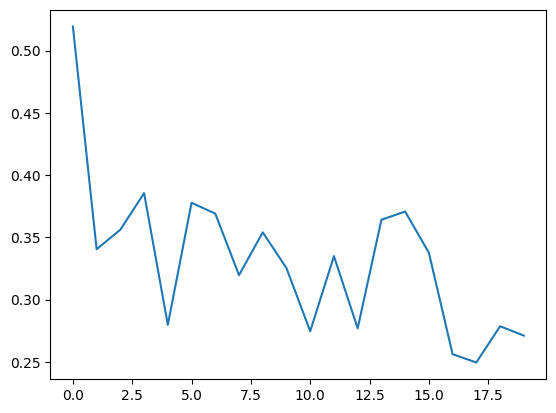

In [59]:
# MLP parameters

g = torch.Generator().manual_seed(2147483647)

n_embedd = 10 # Embedding dim
C = torch.randn((vocab_size, n_embedd), generator=g) # Lookup matrix for embedding
block_size = 3

n_hidden = 200

# Layer 1
W1 = torch.randn((n_embedd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # We want logits to be close to zero. So scaling down weights and removing bias
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# Training

max_steps = 200000
batch_size = 32
lossi = [] # training loss in each step

for i in range(max_steps):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer out
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Yb) #loss function

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the stats
    if i % 10000 == 0:
        print(f'{i:7d} /  {max_steps:7d} :: {loss.item():.4f}')
    
        lossi.append(loss.log10().item())


plt.plot(lossi)

In [60]:
@torch.no_grad
def split_loss(split):

    x, y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, ' loss : ', loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')


train  loss :  2.05790114402771
dev  loss :  2.113706588745117
test  loss :  2.1124987602233887
